## Dimension Reduction ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS # Pour la régression linéaire (avec statsmodels)
from statsmodels.tools.tools import add_constant # Pour l'ajout d'une constante dans statsmodels

from sklearn.preprocessing import PolynomialFeatures # Pour le "feature engineering" polynomial
import statsmodels.api as sm


In [3]:
df = pd.read_csv('Data/train_cleaned.csv')
df = df.dropna()
print(df['vue_note'].mean())
df.head()
df.shape

0.2134433962264151


(16112, 21)

In [4]:
X = df.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note'], axis = 1)
for column in X.columns:
    X[column] = X[column] - X[column].mean()/X[column].std()
y = df['prix']
X = X.merge(df['vue_note'], left_index=True, right_index=True)
X.head()

,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,etat_note,design_note,m2_interieur_15voisins,m2_jardin_15voisins,vue_note
0,480998.296765,-1.948539,-1.918257,147.459318,359.300418,82.668662,64.327037,-1.772479,-1.385408,-0.188191,119.982882,359.067969,0
1,364806.296765,-0.948539,-1.168257,212.459318,730.300418,147.668662,64.327037,-1.772479,-2.385408,0.811809,180.982882,902.067969,0
2,469998.296765,-0.948539,-0.918257,164.459318,1175.300418,164.668662,-0.672963,-1.772479,-2.385408,-0.188191,179.982882,907.067969,0
3,447998.296765,1.051461,0.581743,344.459318,2292.300418,253.668662,90.327037,-0.772479,-2.385408,1.811809,263.982882,2416.067969,0
4,949998.296765,-0.948539,-0.418257,320.459318,723.300418,159.668662,159.327037,-1.772479,-1.385408,-0.188191,275.982882,920.067969,0


# Interprétation des notes ###

In [5]:
def plot_density(note, df):
    plt.hexbin(df.loc[df['vue_note'] == note,'m2_interieur'], df.loc[df['vue_note'] == note,'prix'])
    plt.colorbar()
    plt.show()

def subplot_density(note, df, ax, fig):
    sp = ax.hexbin(df.loc[df['vue_note'] == note,'m2_interieur'], df.loc[df['vue_note'] == note,'prix'])
    ax.set_title('Note: ' + str(note))
    cb = fig.colorbar(sp, ax=ax)
    return sp

### Figure 1 ###

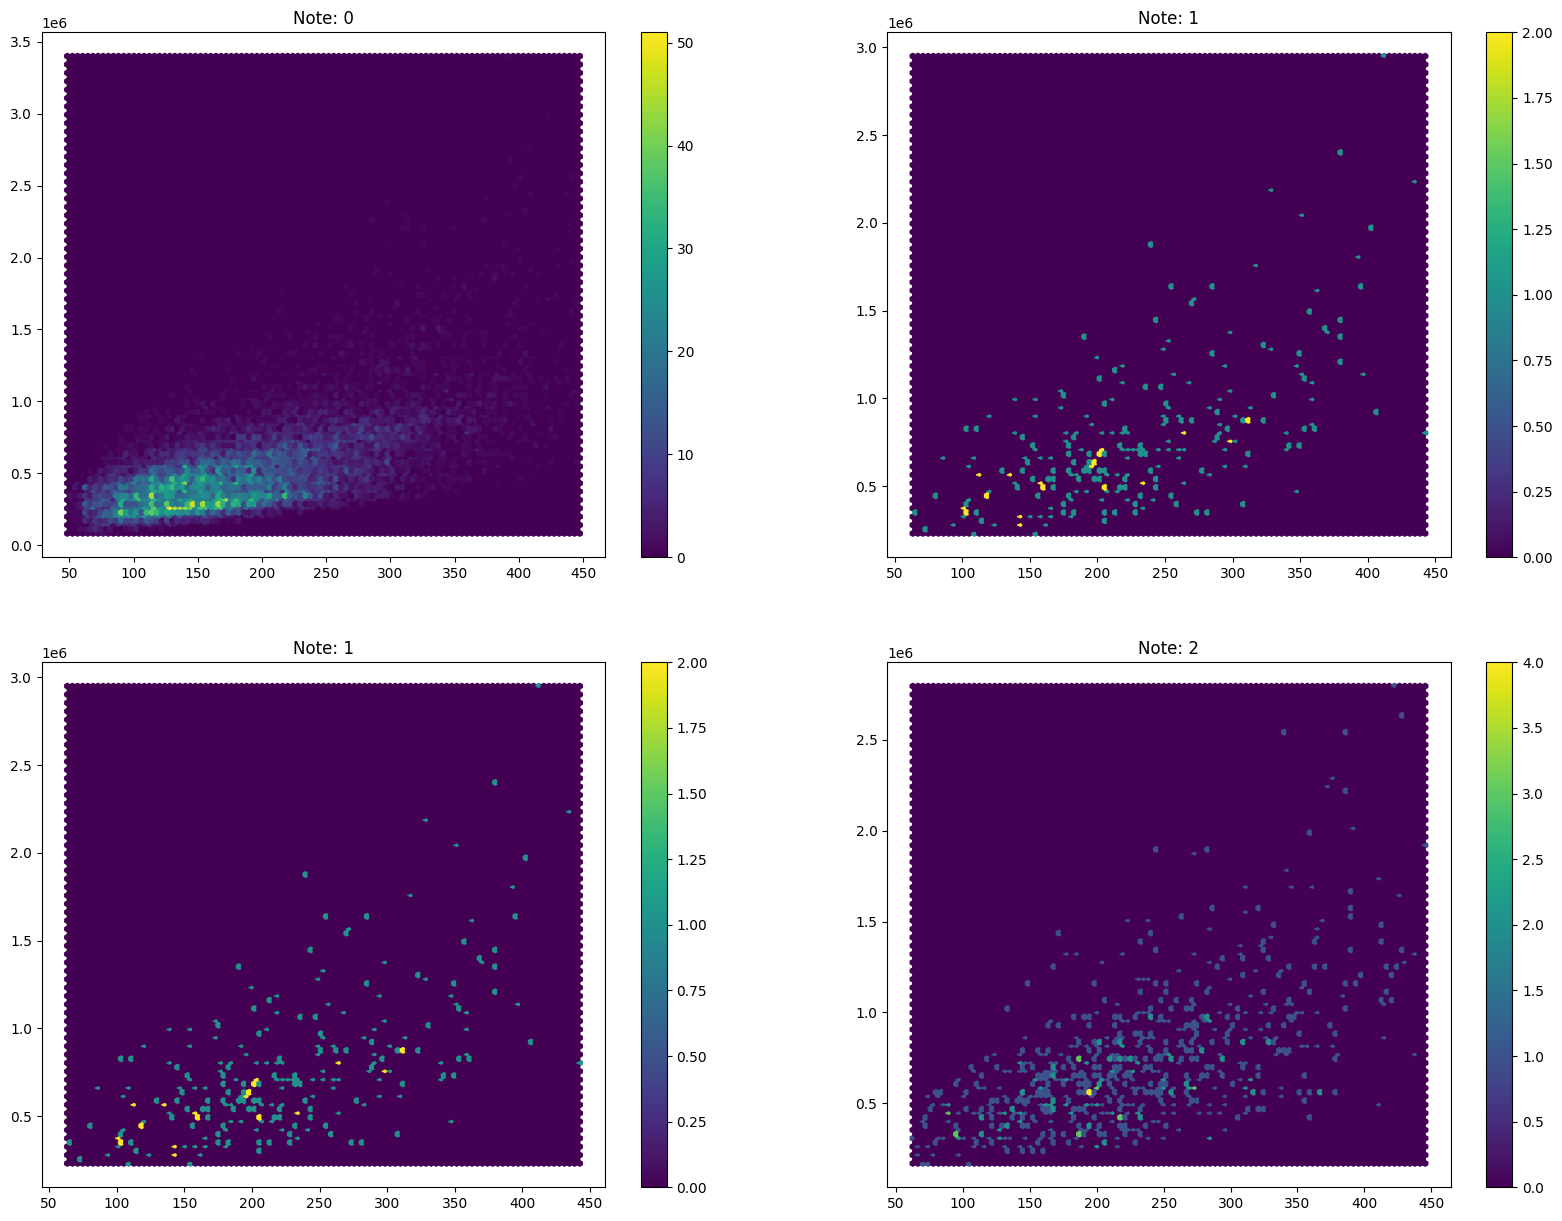

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
for i in range(2):
    for j in range(2):
        subplot_density(i + j, X, ax[i][j], fig)
plt.show()
X.drop('prix', axis = 1, inplace = True)


## Interprétation de la densité ##
On s'aperçoit que seule la catégorie note = 0 présente une condesation très forte de ses notes et de son prix (voir figure 1). On se propose d'élaborer un modèle unique pour ce cas de figure.

# Régressions #

# Régression linéaire #

0.5599667131911876


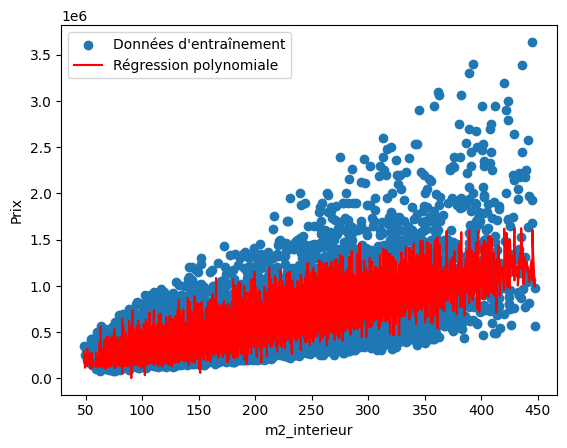

In [7]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
X_new = X.sort_values(by='m2_interieur', inplace=False)
y_pred = reg.predict(X_new)
plt.scatter(X['m2_interieur'], y, label='Données d\'entraînement')
#plt.scatter(X_test['m2_interieur'], y_test, label='Données de test')
plt.plot(X_new['m2_interieur'], y_pred, label='Régression polynomiale', color='red')
plt.xlabel('m2_interieur')
plt.ylabel('Prix')
plt.legend()
plt.show()

0.639668947128335


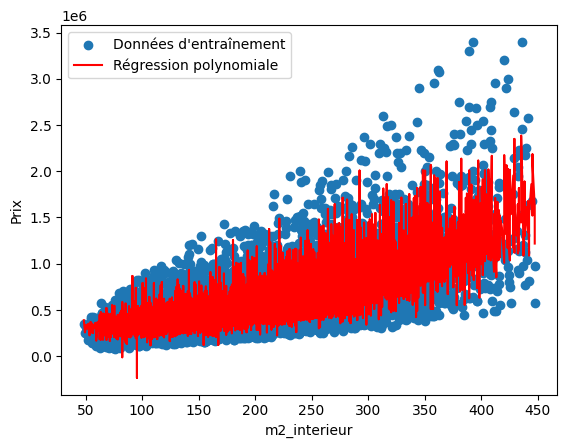

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un pipeline pour transformer les variables indépendantes en un polynôme de degré 2 et ajuster le modèle linéaire
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
score = model.score(X_test, y_test)

y_polreg = model.predict(X_new)
print(model.score(X, y))

# Tracer les résultats
plt.scatter(X_train['m2_interieur'], y_train, label='Données d\'entraînement')
#plt.scatter(X_test['m2_interieur'], y_test, label='Données de test')
plt.plot(X_new['m2_interieur'], y_polreg, label='Régression polynomiale', color='red')
plt.xlabel('m2_interieur')
plt.ylabel('Prix')
plt.legend()
plt.show()


In [9]:
#Erwann
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
y_polreg = model.predict(X_new)

result = pd.concat([df_test['id'], y_polreg], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

## Pour l'instant, c'est notre meilleur score ##

# Régression en trois temps #
Au vu des densités de notes, on effectuera 3 régressions  
-Une pour la note de 0  
-Une dernière pour toutes les autres notes confondues

In [ ]:
df_0 = df.loc[df['vue_note'] < 1]
df_1 = df.loc[df['vue_note'] >= 1]

In [ ]:
X_0 = df_0.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note', 'prix'], axis = 1)
for column in X_0.columns:
    X_0[column] = X_0[column] - X_0[column].mean()/X_0[column].std()
y_0 = df_0['prix']
X_1 = df_1.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note', 'prix'], axis = 1)
for column in X_1.columns:
    X_1[column] = X_1[column] - X_1[column].mean()/X_1[column].std()
y_1 = df_1['prix']

In [ ]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
model_0 = LinearRegression()
model_1 = LinearRegression()

model_0.fit(X_0_train, y_0_train)
model_1.fit(X_1_train, y_1_train)

print(model_0.score(X_0_test, y_0_test))
print(model_1.score(X_1_test, y_1_test))

0.5170213207966394
0.46112174971248865


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regressor
model_0 = DecisionTreeRegressor()
model_1 = DecisionTreeRegressor()

# Fit the model to the training data
model_0.fit(X_0_train, y_0_train)
model_1.fit(X_1_train, y_1_train)

# Evaluate the model
print(model_0.score(X_0_test, y_0_test))
print(model_1.score(X_1_test, y_1_test))


0.20080023268989355
-0.009671175317837566


In [ ]:
# Créer un pipeline pour transformer les variables indépendantes en un polynôme de degré 2 et ajuster le modèle linéaire
model_0 = LinearRegression()
model_1 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Ajuster le modèle sur les données d'entraînement
model_0.fit(X_0_train, y_0_train)
model_1.fit(X_1_train, y_1_train)

# Évaluer le modèle sur les données de test
score_0 = model_0.score(X_0_test, y_0_test)
score_1 = model_1.score(X_1_test, y_1_test)
print(score_0)
print(score_1)
print(model_0.score(X_0, y_0))
print(model_1.score(X_1, y_1))


0.5170213207966394
0.44657389313282914
0.5096009497557893
0.5652728128980378


In [ ]:
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
X_teste = df_test.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note'], axis = 1)

X_teste_0 = X_teste.loc[df_test['vue_note'] == 0]
X_teste_1 = X_teste.loc[df_test['vue_note'] > 0]
y_pred_0 = pd.Series(model_0.predict(X_teste_0), name='prix')  # name is optional, just for clarity
y_pred_1 = pd.Series(model_1.predict(X_teste_1), name='prix')

y_pred = pd.concat([y_pred_0, y_pred_1], axis=0, ignore_index=True)

#create the csv result.csv that concatenate the id and the predicted price


In [ ]:
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)

#### Nouvel essai

In [ ]:
# X_simple = df.loc[df['prix']>df['prix'].quantile(0.05),['m2_etage', 'm2_jardin','m2_etage','m2_soussol','nb_etages']]
# y_simple = df.loc[df['prix']>df['prix'].quantile(0.05),'prix']
X_simple = df[['m2_etage', 'm2_jardin','m2_etage','m2_soussol','nb_etages','vue_note']]
y_simple = df['prix']

In [ ]:
# from sklearn.linear_model import LinearRegression
# from statsmodels.regression.linear_model import OLS
# import statsmodels.api as sm

# def calculate_leverage_cooks(X, y):
#     model = OLS(y, sm.add_constant(X)).fit()
#     leverage = model.get_influence().hat_matrix_diag
#     cooks_distance = model.get_influence().cooks_distance[0]
#     return leverage, cooks_distance

# # Calculer le Leverage et la Cook's Distance pour X_simple et y
# leverage, cooks_distance = calculate_leverage_cooks(X_simple, y)

In [ ]:
# leverage_threshold = 2 * np.mean(leverage)
# cooks_distance_threshold = 10 / len(y)

# influential_observations = (leverage > leverage_threshold) | (cooks_distance > cooks_distance_threshold)

# # Créer un nouveau jeu de données sans les observations influentes
# X_reduced = X_simple[~influential_observations]
# y_reduced = y[~influential_observations]

# print("Nombre d'observations supprimées :", influential_observations.sum())


In [ ]:
X_OLS = df.drop(['date','lat','long','prix','id'], axis = 1)
y_OLS = df['prix']
# Python

In [ ]:
linreg_poly_model = OLS(y_OLS, add_constant(X_OLS))
linreg_poly = linreg_poly_model.fit()
linreg_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     1709.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:18:25   Log-Likelihood:            -2.1852e+05
No. Observations:               16112   AIC:                         4.371e+05
Df Residuals:                   16095   BIC:                         4.372e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.208e+06   3.17e+06      1.329      0.184      -2e+06    1.04e+07
nb_chambres              -2.6e+04   2278.527    -11.411      0.000   -3.05e+04   -2.15e+04
nb_sdb                  3.699e+04   3643.560     10.152      0.000    2.98e+04    4.41e+04
m2_interieur            4459.5353   4413.445      1.010      0.312   -4191.308    1.31e+04
m2_jardin                 -1.3815      1.579     -0.875      0.382      -4.477       1.714
m2_etage               -3282.3817   4409.619     -0.744      0.457   -1.19e+04    5360.964
m2_soussol             -3102.8737   4435.199     -0.700      0.484   -1.18e+04    5590.611
nb_etages                3.45e+04   3992.226      8.642      0.000    2.67e+04    4.23e+04
vue_mer                 4.342e+05      2e+04     21.681      0.000    3.95e+05    4.73e+05
vue_note                 5.02e+04   2642.068     19.000      0.000     4.5e+04    5.54e+04
etat_note               2.702e+04   2654.950     10.176      0.000    2.18e+04    3.22e+04
design_note             1.271e+05   2404.778     52.852      0.000    1.22e+05    1.32e+05
annee_construction     -3318.7341     76.758    -43.236      0.000   -3469.189   -3168.279
annee_renovation          16.1499      3.943      4.095      0.000       8.420      23.879
m2_interieur_15voisins   511.5506     42.029     12.171      0.000     429.169     593.933
m2_jardin_15voisins      -16.8492      2.420     -6.963      0.000     -21.592     -12.106
zipcode                   14.4972     31.779      0.456      0.648     -47.793      76.787
==============================================================================
Omnibus:                     6875.477   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80755.643
Skew:                           1.728   Prob(JB):                         0.00
Kurtosis:                      13.409   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X_OLS = df.drop(['date','lat','long','prix','id','m2_jardin','zipcode','annee_renovation'], axis = 1)
linreg_poly_model = OLS(y_OLS, add_constant(X_OLS))
linreg_poly = linreg_poly_model.fit()
linreg_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2100.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:18:25   Log-Likelihood:            -2.1853e+05
No. Observations:               16112   AIC:                         4.371e+05
Df Residuals:                   16098   BIC:                         4.372e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   5.849e+06   1.35e+05     43.382      0.000    5.58e+06    6.11e+06
nb_chambres             -2.63e+04   2272.680    -11.570      0.000   -3.07e+04   -2.18e+04
nb_sdb                  3.905e+04   3608.523     10.820      0.000     3.2e+04    4.61e+04
m2_interieur            4230.5525   4411.612      0.959      0.338   -4416.699    1.29e+04
m2_etage               -3051.9556   4407.758     -0.692      0.489   -1.17e+04    5587.740
m2_soussol             -2868.2319   4433.602     -0.647      0.518   -1.16e+04    5822.121
nb_etages               3.555e+04   3936.119      9.032      0.000    2.78e+04    4.33e+04
vue_mer                 4.398e+05      2e+04     22.003      0.000    4.01e+05    4.79e+05
vue_note                5.056e+04   2628.928     19.233      0.000    4.54e+04    5.57e+04
etat_note               2.489e+04   2584.850      9.629      0.000    1.98e+04       3e+04
design_note             1.272e+05   2402.286     52.963      0.000    1.23e+05    1.32e+05
annee_construction     -3427.5350     68.935    -49.721      0.000   -3562.655   -3292.415
m2_interieur_15voisins   500.4841     41.447     12.075      0.000     419.243     581.725
m2_jardin_15voisins      -18.1912      1.662    -10.944      0.000     -21.449     -14.933
==============================================================================
Omnibus:                     6894.739   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81160.127
Skew:                           1.734   Prob(JB):                         0.00
Kurtosis:                      13.434   Cond. No.                     2.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Python
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.api import OLS, add_constant

# Define the degree of the polynomial features
degree = 2

# Create a PolynomialFeatures object
poly = PolynomialFeatures(degree)

# Transform the data
X_poly = poly.fit_transform(X_OLS)

# Fit the model
linreg_poly_model = OLS(y_OLS, add_constant(X_poly))
linreg_poly = linreg_poly_model.fit()

# Print the summary
print(linreg_poly.summary())

NameError: name 'X_OLS' is not defined

In [ ]:
Model_simple = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
Model_simple.fit(X_simple, y_simple)
print(Model_simple.score(X_simple, y_simple))

0.5505186102457332


In [ ]:
moyenne_vue = {}
ecart_type_vue = {}
for i in range(4):
    moyenne_vue[i] = df.loc[df['vue_note'] == i, 'prix'].mean()
    ecart_type_vue[i] = df.loc[df['vue_note'] == i, 'prix'].std()
moyenne_vue

{0: nan, 1: 775097.4920634921, 2: 733891.4468390804, 3: 927128.7507692308}

In [ ]:
def prediction(X):
    X_simple = X[['m2_etage', 'm2_jardin','m2_etage','m2_soussol','nb_etages']]
    naive_price = Model_simple.predict(X_simple) + moyenne_vue[X['vue_note']] / ecart_type_vue[X['vue_note']]
    return naive_price
    

In [ ]:
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
X_teste = df_test.drop(['date','lat','long','id','m2_jardin','zipcode','annee_renovation'], axis = 1)
for index, row in X_teste.iterrows():
    if row['vue_note'] == 0:
        row['vue_note'] = 0.2355412897578056
X_teste_poly = poly.fit_transform(X_teste)
y_pred = linreg_poly.predict(sm.add_constant(X_teste_poly))
#create the csv result.csv that concatenate the id and the predicted price
y_pred = pd.Series(y_pred, name='prix')  # name is optional, just for clarity

In [ ]:
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)

## On teste le xgboost

In [11]:
df = pd.read_csv('Data/train_cleaned.csv')
df = df.dropna()
print(df['vue_note'].mean())
df.head()

0.2134433962264151


,id,date,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,...,vue_note,etat_note,design_note,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long
0,4443800785,2014-11-21T00:00:00Z,481000,2,1.00,150,360,85,65,1.0,...,0,4,7,1924,0,123,360,98117,47.6855,-122.391
1,2473003210,2015-03-13T00:00:00Z,364808,3,1.75,215,731,150,65,1.0,...,0,3,8,1967,0,184,903,98058,47.4524,-122.146
2,6743700335,2014-06-04T00:00:00Z,470000,3,2.00,167,1176,167,0,1.0,...,0,3,7,1956,1990,183,908,98033,47.6935,-122.173
3,9406510130,2015-05-05T00:00:00Z,448000,5,3.50,347,2293,256,91,2.0,...,0,3,9,1998,0,267,2417,98038,47.3832,-122.057
4,868000905,2014-07-08T00:00:00Z,950000,3,2.50,323,724,162,160,1.0,...,0,4,7,1941,1998,279,921,98177,47.7047,-122.378


In [12]:
features = ['nb_chambres', 'm2_etage', 'nb_sdb', 'm2_interieur', 'm2_soussol','m2_jardin', 'nb_etages', 'vue_mer', 'vue_note', 'etat_note', 'design_note', 'annee_construction', 'annee_renovation', 'm2_interieur_15voisins', 'm2_jardin_15voisins', 'zipcode', 'lat', 'long']

In [13]:
X = df[features]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [16]:
params = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'eta': 0.3,
    'subsample':0.95,
    'learning_rate':0.01
}


In [17]:
model = xgb.train(params, dtrain, num_boost_round=10000)

In [18]:
y_pred = model.predict(dtrain)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 1017656698.254783
R-squared Score: 0.9893603140589611


In [19]:
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 9537328274.963522
R-squared Score: 0.8983928063435856


In [20]:
df_test = pd.read_csv('Data/test_cleaned.csv')
df_test = df_test.dropna()
X_teste = df_test[features]
X_teste = xgb.DMatrix(X_teste)
y_pred = model.predict(X_teste)
#create the csv result.csv that concatenate the id and the predicted price
y_pred = pd.Series(y_pred, name='prix')  # name is optional, just for clarity
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result_no_feat_cleaned_data.csv', index=False)

### Feature Engineering on the date column



In [21]:
df = pd.read_csv('Data/train_cleaned_feat.csv')
df = df.dropna()
print(df['vue_note'].mean())
df.head()

0.2134433962264151


,id,date,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,...,design_note,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long,cos_month,day_count
0,4443800785,2014-11-21T00:00:00Z,481000,2,1.00,150,360,85,65,1.0,...,7,1924,0,123,360,98117,47.6855,-122.391,8.660254e-01,203
1,2473003210,2015-03-13T00:00:00Z,364808,3,1.75,215,731,150,65,1.0,...,8,1967,0,184,903,98058,47.4524,-122.146,6.123234e-17,315
2,6743700335,2014-06-04T00:00:00Z,470000,3,2.00,167,1176,167,0,1.0,...,7,1956,1990,183,908,98033,47.6935,-122.173,-1.000000e+00,33
3,9406510130,2015-05-05T00:00:00Z,448000,5,3.50,347,2293,256,91,2.0,...,9,1998,0,267,2417,98038,47.3832,-122.057,-8.660254e-01,368
4,868000905,2014-07-08T00:00:00Z,950000,3,2.50,323,724,162,160,1.0,...,7,1941,1998,279,921,98177,47.7047,-122.378,-8.660254e-01,67


In [22]:
features = ['nb_chambres', 'm2_etage', 'nb_sdb', 'm2_interieur', 'm2_soussol','m2_jardin', 'nb_etages', 'vue_mer', 'vue_note', 'etat_note', 'design_note', 'annee_construction', 'annee_renovation', 'm2_interieur_15voisins', 'm2_jardin_15voisins', 'zipcode', 'lat', 'long', 'cos_month', 'day_count']
X = df[features]

In [23]:
X = df[features]
y = df['prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'eta': 0.3,
    'subsample':0.95,
    'learning_rate':0.01
}

In [25]:
model = xgb.train(params, dtrain, num_boost_round=10000)

In [26]:
y_pred = model.predict(dtrain)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 876963674.6690481
R-squared Score: 0.9908312713941946


In [27]:
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 9397942447.422733
R-squared Score: 0.8998777717724338


In [35]:
df_test = pd.read_csv('Data/test_cleaned_feat.csv')
df_test.shape

(4287, 22)

In [37]:
df_test = df_test.dropna()
X_teste = df_test[features]
X_teste = xgb.DMatrix(X_teste)
y_pred = model.predict(X_teste)
#create the csv result.csv that concatenate the id and the predicted price
y_pred = pd.Series(y_pred, name='prix')  # name is optional, just for clarity
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)